## 10/24 Sinusoid generated as in 10.14, but homoscedastic errors, freq. grid from E.Bellm, overplot P_LS 10.49 

Eq. 10.49 : 
    
$P_{LS}(\omega) \approx 1 - \frac{\sigma^{2}}{V} - \frac{(\omega - \omega_{0})^{2}}{NV\sigma_{\omega}^{2}}$ where


$\sigma$ is the standard deviation of a Gaussian from which errors are generated, 

$\sigma_{\omega} = \omega_{1/2} [2N(V - \sigma^{2})]^{-1/2}$ is the uncertainty in the location of the peak (its width)

where $\omega_{1/2}$ is the FWHM of the peak, and for fixed length $T$ time series, $\omega_{1/2} \propto T$ (WHY?)

$V = \frac{1}{N} \sum_{j=1}^{N}{y_{j}^{2}}$

In [163]:
# calculate the frequency grid in a manual way : I trust that 
# more than the autopower of scipy LombScargle implementation, 
# and having to manually set minimum_frequency and maximum_frequency...
# because here at least I understand what's going on step by step ...
 
def frequency_grid(times, astropy = True , n = 10, samples_per_peak=5, nyquist_factor=5):
    times = np.sort(times)
    baseline = abs(min(times) - max(times))
    omega_min =  2* np.pi / baseline
      
    if astropy == False  :
        delta_t  = np.zeros(len(times)-1) 
        for i in range(len(times)-1):
            delta_t[i] = (times[i+1]-times[i])
        omega_max = np.pi /  np.median(delta_t)
        # one way : from Eric Bellm... n = 5 
        # another way : from the Yellow Book, n = 10 
        n_bins =   int(n * (omega_max - omega_min) /omega_min )
        
    if astropy == True : 
        # yet another way : astropy autofrequency, part of autopower method 
        # of LombScargle class 
        n_samples = len(times)

        dw = omega_min  / samples_per_peak 
        omega_min_update = 0.5 * dw
        n_bins = int(0.5 * samples_per_peak * nyquist_factor * n_samples)
 
        # omegas = omega0 + dw * np.arange(Nomega)
        
        # implementing astropy method 
        # with the same methodology  as above...
        omega_max = omega_min_update + dw* n_bins
      
    
    print('N bins'%n_bins)
    print('omega max'%omega_max)
    #print('Using {} bins for periodogram'.format(n_bins))
    return np.linspace(omega_min, omega_max, n_bins)

# Source of the astropy autopower()  implementation : 
# http://docs.astropy.org/en/stable/_modules/astropy/stats/lombscargle/core.html#LombScargle.autopower 

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
from astroML.time_series import lomb_scargle



1) fix $\sigma_{0}=0.5$, execute few times, to see if the blue line (10.47 estimate) jumps around... This would be due to statistical fluctuations of the sample variance, since the blue line estimates the peak height by 

$P = 1 - \frac{\sigma^2 } {\mbox{Variance}}$ 

only plot the black (periodogram of the noisy measurements), and orange (the Gaussian fit). No need to plot the grey (a periodogram of a perfectly sampled distribution with no noise). 

In [52]:
# Calculate 10.14 
# Take only the upper plots

# Generate the data
np.random.seed(42)

# the input frequency 
f0 = 1 / (2 * np.pi) 
sigma_0 = 0.5
A = 1 
t_max = 100
homoscedastic = True
N = 160
fit_gaussian = True  # NOTE : for N = 10 , the peak looks so bad that it doesn't even 
     # resemble a Gaussian which is why fitting fails... 
    
gauss_width = 0.02 # for the Gaussian fit, a guess of the extent of Gaussian... 

# Observed time series : with noise ...
# my version : homoscedastic noise ... 
N_iterations = 1000
plot=False  # if many iterations, set  that to False...
verbose = False


result['sigma_omega_1'] = np.zeros(N_iterations)
result['sigma_omega_2'] = np.zeros(N_iterations)


for i in range(N_iterations):
    if homoscedastic == True: 
        #print('Sampling %d points'%N)
        t_obs = t_max * np.random.random(N)
        ei = np.random.normal(loc=0.0, scale=sigma_0, size=len(t_obs))
        y_obs = A*np.sin(2.0 * np.pi *f0 *  t_obs )  + ei 
        dy = np.ones_like(t_obs) * sigma_0

        # True underlying time series... 
        t = np.linspace(0, t_max, 1000)
        y = A*np.sin(2.0*np.pi * f0 * t )

    # The 10.14 version : heteroscedastic noise... 
    if homoscedastic == False : 
        t_obs = t_max * np.random.random(N)  # 40 observations in at **random** (to avoid aliasing frequencies...) 
                                            # times 100 days
        y_obs = A*np.sin(2.0*np.pi * f0 * t_obs )
        dy = 0.1 + 0.1 *np.random.random(y_obs.shape) # this makes heteroscedastic errors.... 
        y_obs += np.random.normal(0, dy)

        # True underlying time series... 
        t = np.linspace(0, t_max, 1000)
        y = A*np.sin(2.0*np.pi * f0 * t )

    from astroML.plotting import setup_text_plots
    setup_text_plots(fontsize=12, usetex=True)
    #
    # ------------------------------------------------------------
    # Compute the periodogram
    # ------------------------------------------------------------
    #
    # There are various ways of choosing the frequency grid - 
    # I wrote a code that calculates that (based on Eric Bellm’s 
    # notebook exercises from this summer), instead of using .autopower() 
    # method (because I could better understand how it works).  
    # This seems a more efficient choice than a fixed grid (which 
    # would be too rigid if a priori we don’t know the periodicities involved). 

    omega =  frequency_grid(t_obs)  # angular frequencies 
    #omega = np.linspace(0, 2, 5001)[1:]  
    P_obs = lomb_scargle(t_obs, y_obs, dy, omega)
    #P_window = lomb_scargle(t_obs, y_window, 1, omega,
    #                        generalized=False, subtract_mean=False)
    #P_true = lomb_scargle(t, y, 1, omega)

    frequency = omega / (2 * np.pi)

    #
    # ------------------------------------------------------------
    # Gaussian fit ...
    # ------------------------------------------------------------
    #
    
    if fit_gaussian == True :
        # Notes: 
        # FWHM in Gaussian approximation is   FWHM = 2 sqrt(2 ln(2)) sigma ~ 2.3548 sigma...

        # I use Gaussian approximation by simply fitting a Gaussian to the main peak, and 
        # thus I get sigma_omega 
        #
        # Following http://stackoverflow.com/questions/10880266/robust-algorithm-for-detection-of-peak-widths 

        from scipy.optimize import leastsq
        from scipy import *

        def gaussian(x, A, x0, sig):
            return A*exp(-(x-x0)**2/(2.0*sig**2))

        def fit(p,x):
            return np.sum([gaussian(x, p[i*3],p[i*3+1],p[i*3+2]) 
                           for i in range(len(p)//3)],axis=0)

        err = lambda p, x, y: fit(p,x)-y

        #params are our intitial guesses for fitting gaussians, 
        #(Amplitude, x value, sigma):
        params = [1, f0, gauss_width] 
        #params = np.asarray(params).flatten()
        #f0 = frequency[P_true == max(P_true)]

        # we assume that somehow we are able to find the true frequency...
        # I just use the input frequency since it is known...
        f_range = (frequency > f0 - gauss_width) * ( frequency < f0 + gauss_width  )

        # fit only to part of P_LS around the peak ... 
        results, value = leastsq(err, params, args=(frequency[f_range],P_obs[f_range]))
        if verbose == True  : 
            for res in results.reshape(-1,3):
                print("Gaussian :    amplitude, position, sigma")
                print(res)


        # Quadratic doesn't work very well... Plot a Gaussian instead ! 
        #omega_peak = np.linspace(omega_0  - 0.3, omega_0+0.3, 100)
        #P_LS_omega = P_LS_0 - (omega_peak - omega_0)**2.0 / (N*V*(sigma_omega**2.0))

        P_LS_f0 = fit(results,frequency[f_range])


        # Zoom in on the peak... , find new omegas and powers 
        freq_max = 2*np.pi*f0 / 0.75
        freq_min = 2*np.pi*f0 / 1.5
        n_bins = 2000
        omega_zoom =  np.linspace(freq_min, freq_max, n_bins)
        frequency_zoom = omega_zoom / (2*np.pi)
        P_obs2 = lomb_scargle(t_obs, y_obs, dy, omega_zoom)

        # calculate  10.47 P_LS peak height estimate...
        V = (1 / len(y_obs)) * np.sum(y_obs*y_obs) 
        P_LS_0 = 1.0 - (sigma_0 ** 2.0 ) / V

        # Calculate 10.50 : estimate FWHM from the Gaussian fit,  and 
        # thus get sigma_omega from the data ...
        sigma = results[2]
        FWHM_frequency = 2.0 * np.sqrt(2.0 * np.log(2.0)) * sigma
        omega_12 = FWHM_frequency * 2 * np.pi 
        sigma_omega_1 = omega_12 * (1.0 / np.sqrt(2 * N * (V - sigma_0 ** 2.0)))

        # Calculate the theory value of sigma_omega (eq. 10.51 : 10.53)

        # below : x is the omega_0, the peak angular frequency,  equal  to f0 * 2 pi
        R_prim = lambda x : -np.sum(y_obs * t_obs * np.sin(x * t_obs))
        R_bis = lambda x : -np.sum(y_obs * t_obs*t_obs * np.cos(x * t_obs))
        I_prim = lambda x : np.sum(y_obs * t_obs * np.cos(x * t_obs))
        I_bis = lambda x : -np.sum(y_obs * t_obs*t_obs * np.sin(x * t_obs))
        R = lambda x : np.sum(y_obs * np.cos(x * t_obs))
        I = lambda x : np.sum(y_obs * np.sin(x * t_obs))
        omega0 = f0 * 2*np.pi
        second_peak_P_der = (2.0 / N) * np.abs(R_prim(omega0)**2.0 + R(omega0) * R_bis(omega0) \
                                            +  I_prim(omega0)**2.0 + I(omega0) * I_bis(omega0))
        sigma_omega_2 = 1.0 / np.sqrt(second_peak_P_der)
        
        # store results in a dictionary 
        result['sigma_omega_1'][i] = sigma_omega_1
        result['sigma_omega_2'][i] = sigma_omega_2
        
    
    if verbose == True : 
        print('sigma omega estimate from 10.50 f(FWHM, V, sigma0) = %f'%sigma_omega_1)
        print('sigma omega estimate from 10.48 f(omega0, y_obs, t_obs, N)= %f'%sigma_omega_2)
        print('\n')
        print('sigma 10.50 / sigma 10.48 = %f'%(sigma_omega_2 / sigma_omega_1))
    
    #------------------------------------------------------------
    # Prepare the figures
    
    if plot == True : 
        fig, ax = plt.subplots(1,3,figsize=(13, 4))
        fig.subplots_adjust(bottom=0.15, hspace=0.35, wspace=0.25,
                            left=0.11, right=0.95)

        ax[0].plot(t, y, '-', c='gray')
        ax[0].errorbar(t_obs, y_obs, dy, fmt='.k', capsize=1, ecolor='#444444')
        ax[0].text(0.96, 0.92, "Data", ha='right', va='top', transform=ax[0].transAxes)
        ax[0].text(0.46, 0.92, r"$\sigma_{0}=$"+r"${0:.1f}$".format(sigma_0), ha='right', va='top', 
                   transform=ax[0].transAxes, fontsize=15)
        ax[0].set_ylim(-1.5, 1.8)
        ax[0].set_xlabel('$t$')
        ax[0].set_ylabel('$y(t)$')


        #ax[1].fill(frequency, P_true, fc='gray', ec='gray')
        ax[1].plot(frequency, P_obs, '-', c='black')
        ax[1].text(0.7, 0.8, "Data PSD", ha='right', va='top', transform=ax[1].transAxes)
        ax[1].set_ylim(-0.1, 1.1)
        ax[1].set_xlabel('$f$')
        ax[1].set_ylabel(r'$P_{\rm LS}(f)$')

        # plot the peak height estimate from 10.47 ...
        ax[1].axhline(P_LS_0, ls='--')
        
        if fit_gaussian == True : 
            # plot the Gaussian fit... 
            # increasing the omega grid in the vicinity of the peak...
            ax[1].plot(frequency[f_range],P_LS_f0, c='orange', lw=2, ls='--')



        # plot the zoom-in around the peak...
        ax[2].plot(frequency_zoom, P_obs2,  '-', c='black')
        ax[2].text(0.7, 0.8, "Data PSD: \n zoomed", ha='left', va='top', transform=ax[2].transAxes)
        
        if fit_gaussian == True : 
            ax[2].plot(frequency[f_range],P_LS_f0, c='orange', lw=2, ls='--')
        
        
            t= tuple([sigma_omega_2, sigma_omega_1])
            ax[2].text(0.05, 0.8, r"$\sigma_{\omega,2} / \sigma_{\omega,1}=$"+"\n"+\
                       r"${0:.4f}/{1:.4f}$".format(*t)+"\n"+\
                       r"$={:.4f}$".format(sigma_omega_2 / sigma_omega_1),ha='left', va='top',
                       transform=ax[2].transAxes, fontsize=15)
        plt.savefig('../data_products/Nov_09_Sinusoid_N_'+str(N)+'_sig_'+str(sigma_0)+'_'+str(i)+'.png')
        plt.show()
print('done')

done


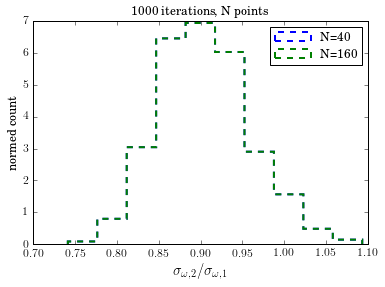

In [285]:


fig,ax = plt.subplots()
ax.hist(result40['sigma_omega_2'] / result40['sigma_omega_1'], histtype='step', ls='--',lw=2, label='N=40', normed=True)
ax.hist(result160['sigma_omega_2'] / result160['sigma_omega_1'], histtype='step', ls='--',lw=2, label='N=160',normed=True)
ax.set_title('{:d} iterations,  N  points '.format(N_iterations,N))
ax.set_xlabel(r'$\sigma_{\omega,2} / \sigma_{\omega,1}$', fontsize=15)
ax.set_ylabel('normed count')
plt.legend()
plt.savefig('../data_products/Nov_09_Sinusoids_N_40_160_sigma_0.5_ratio_eq_10.50_10.48.png')

In [1]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
from astroML.time_series import lomb_scargle




In [4]:
import sys
sys.path.insert(0, '/Users/chris/GradResearch/SDSS_S82_FP_research/S82analysis/packages/')
import frequencyFunctions as freq
import imp
imp.reload(freq)

<module 'frequencyFunctions' from '/Users/chris/GradResearch/SDSS_S82_FP_research/S82analysis/packages/frequencyFunctions.py'>

Repeat N_iterations  times ,  don't plot anything - store the results of the periodogram peak height, and the estimate of eq. 10.47 in a dictionary.  Repeat for N=10,40,160 samples , to plot the histogram below.

Note : if need to investigate any particular set of parameters and make a plot, just set  ** plot=True **

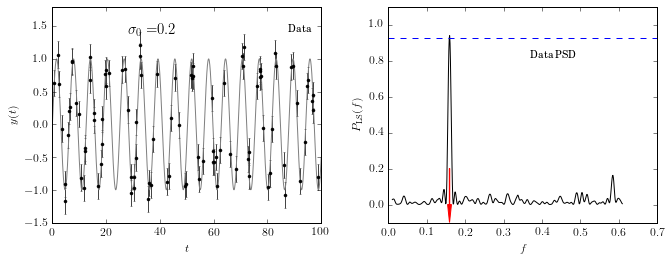

done


In [5]:
# Do the same experiment many times (changing nothing), record the P_LS0, and plot the histogram 

# Calculate 10.14 
# Take only the upper plots

# Generate the data
np.random.seed(42)

# the input frequency 
f0 = 1 / (2 * np.pi) 
sigma_0 = 0.2

A = 1 
t_max = 100
homoscedastic = True
N = 100

# Observed time series : with noise ...
# my version : homoscedastic noise ... 
result = {}
N_iterations = 1
result['P_LS_0'] = np.zeros(N_iterations)
result['P_LS_max_var'] = np.zeros(N_iterations)
result['P_LS_max_fix'] = np.zeros(N_iterations)

for i in range(N_iterations):
    if homoscedastic == True: 
        t_obs = t_max * np.random.random(N)
        ei = np.random.normal(loc=0.0, scale=sigma_0, size=len(t_obs))
        y_obs = A*np.sin(2.0 * np.pi *f0 *  t_obs )  + ei 
        dy = np.ones_like(t_obs) * sigma_0

        # True underlying time series... 
        t = np.linspace(0, t_max, 1000)
        y = A*np.sin(2.0*np.pi * f0 * t )

    # The 10.14 version : heteroscedastic noise... 
    if homoscedastic == False : 
        t_obs = t_max * np.random.random(N)  # 40 observations in at **random** (to avoid aliasing frequencies...) 
                                            # times 100 days
        y_obs = A*np.sin(2.0*np.pi * f0 * t_obs )
        dy = 0.1 + 0.1 *np.random.random(y_obs.shape) # this makes heteroscedastic errors.... 
        y_obs += np.random.normal(0, dy)

        # True underlying time series... 
        t = np.linspace(0, t_max, 1000)
        y = A*np.sin(2.0*np.pi * f0 * t )

    # ------------------------------------------------------------
    # Compute the periodogram : variable grid 
    # ------------------------------------------------------------
    method = 'AstroML'
    omega = freq.frequency_grid(t_obs, method = method) # custom grid 
    #omega = np.linspace(0, 2, 1001)[1:] # fixed grid 
    P_obs = lomb_scargle(t_obs, y_obs, dy, omega)
    frequency = omega / (2 * np.pi)
    
    #
    # 10.47 : peak height estimate 
    #
    V = (1 / len(y_obs)) * np.sum(y_obs*y_obs) 
    P_LS_0 = 1.0 - (sigma_0 ** 2.0 ) / V
    
    # save resulting peak height of the periodogram of the noisy sample,
    # and the estimate of the peak height 
    result['P_LS_max_var'][i] = max(P_obs)
    result['P_LS_0'][i] = P_LS_0  
    
    # ------------------------------------------------------------
    # Compute the periodogram : fixed grid 
    # ------------------------------------------------------------

    #omega = frequency_grid(t_obs) # custom grid 
    #omega = np.linspace(0, 2, 1001)[1:] # fixed grid 
    #P_obs = lomb_scargle(t_obs, y_obs, dy, omega)
    #frequency = omega / (2 * np.pi)
    # save resulting peak height of the periodogram of the noisy sample,
    result['P_LS_max_fix'][i] = max(P_obs)

    
    #------------------------------------------------------------
    # Prepare the figures
    plot = True 
    if plot == True : 
        fig, ax = plt.subplots(1,2,figsize=(10, 4))
        fig.subplots_adjust(bottom=0.15, hspace=0.35, wspace=0.25,
                            left=0.11, right=0.95)

        ax[0].plot(t, y, '-', c='gray')
        ax[0].errorbar(t_obs, y_obs, dy, fmt='.k', capsize=1, ecolor='#444444')
        ax[0].text(0.96, 0.92, "Data", ha='right', va='top', transform=ax[0].transAxes)
        ax[0].text(0.46, 0.92, r"$\sigma_{0}=$"+r"${0:.1f}$".format(sigma_0), ha='right', va='top', 
                   transform=ax[0].transAxes, fontsize=15)
        ax[0].set_ylim(-1.5, 1.8)
        ax[0].set_xlabel('$t$')
        ax[0].set_ylabel('$y(t)$')


        #ax[1].fill(frequency, P_true, fc='gray', ec='gray')
        ax[1].plot(frequency, P_obs, '-', c='black')
        ax[1].text(0.7, 0.8, "Data PSD", ha='right', va='top', transform=ax[1].transAxes)
        ax[1].set_ylim(-0.1, 1.1)
        ax[1].set_xlabel('$f$')
        ax[1].set_ylabel(r'$P_{\rm LS}(f)$')

        # plot the 10.47 P_LS peak height estimate...
        ax[1].axhline(P_LS_0, ls='--')
        
        # plot the true frequency location
        #ax[1].axvline(f0,ymin=0, ymax=0.2, ls='-', color='red', lw=2)
        ax[1].arrow(f0, 0.2, 0, -0.2, head_width=0.01, head_length=0.1, fc='red', ec='red')  
        plt.savefig('../data_products/Jan_13_Sinusoid_sig_'+str(sigma_0)+'_autofrequency_'+str(i)+'.png')
        plt.show()
print('done')

In [159]:
times = np.sort(t_obs)
baseline = abs(min(times) - max(times))
omega_min =  2* np.pi / baseline
delta_t  = np.zeros(len(times)-1) 
for i in range(len(times)-1):
    delta_t[i] = (times[i+1]-times[i])
omega_max = np.pi /  np.median(delta_t)  

n = 10 
n_bins_1 =  int(n * (omega_max - omega_min) /omega_min)
omega1 = np.linspace(omega_min, omega_max, n_bins_1)

samples_per_peak = 5
nyquist_factor = 5 
t = t_obs
baseline = max(times) - min(times)
n_samples = t.size

df = 1. / baseline / samples_per_peak
f0 = 0.5 * df
Nf = int(0.5 * samples_per_peak * nyquist_factor * n_samples)

freq = f0 + df * np.arange(Nf)
omega2 = 2 * np.pi * freq

dw = omega_min  / samples_per_peak 
omega0 = 0.5 * dw
n_bins_3 = int(0.5 * samples_per_peak * nyquist_factor * n_samples)
omega3  = omega0 + dw* np.arange(n_bins_3)


omega_max = omega0 + dw* Nomega
omega4 = np.linspace(omega0, omega_max, n_bins_3)

In [131]:
times = t_obs
times = np.sort(times)
freq_min =  2* np.pi / abs(min(times) - max(times))
delta_t  = np.zeros(len(times)-1) 
for i in range(len(times)-1):
    delta_t[i] = (times[i+1]-times[i])
freq_max = np.pi /  np.median(delta_t)  

omega_min = 2*np.pi * freq_min

n_bins =   5 * 2*np.pi*(freq_max - freq_min) /omega_min 
n_bins = int(n_bins)
print('Using {} bins'.format(n_bins))
omegas = np.linspace(freq_min, freq_max, n_bins)



Using 17 bins


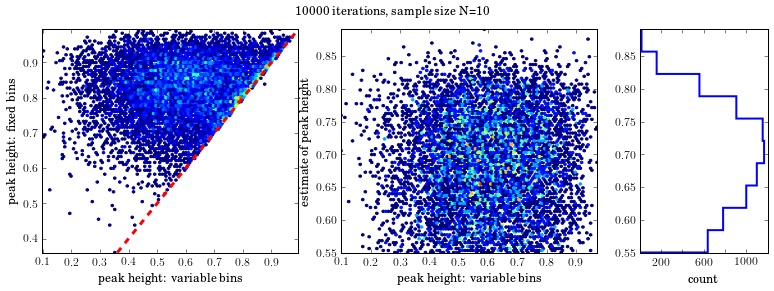

In [125]:
# how good is the estimate  from eq. 10.46...
# problem here is that for each iteration I did change the number of bins...
# see what happens if I fix the bin width...
fig,ax = plt.subplots(1,3, figsize=(13,4),gridspec_kw = {'width_ratios':[2,2,1]})
fig.suptitle('{:d} iterations, sample size  N={:d}'.format(N_iterations,N))


#ax[0].set_title('Height of P\_LS')
ax[0].hexbin(result['P_LS_max_var'], result['P_LS_max_fix'],mincnt=1)
x = np.linspace(min(result['P_LS_max_fix']), max(result['P_LS_max_fix']))
ax[0].plot(x,x, lw=3, ls='--', color='red')
ax[0].set_xlabel('peak height: variable bins')
ax[0].set_ylabel('peak height: fixed bins')

H, xedges, yedges = np.histogram2d(result['P_LS_max_var'],result['P_LS_0'],bins=40)
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
 
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
 
# Plot 2D histogram using pcolor
#ax[1].pcolormesh(xedges,yedges,Hmasked)

ymin = 0.55
mask = result['P_LS_0'] > ymin

ax[1].hexbin(result['P_LS_max_var'][mask],result['P_LS_0'][mask],mincnt=1)
# http://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set

ax[1].set_ylim(ymin)
ax[1].set_xlabel('peak height: variable bins')
ax[1].set_ylabel('estimate of peak height')

ax[2].hist(result['P_LS_0'][mask], histtype='step', lw=2,orientation="horizontal")
ax[2].set_ylim(ax[1].get_ylim()[0],ax[1].get_ylim()[1])
ax[2].set_xlabel('count')
#ax[2].get_yaxis().set_ticks([])
for label in ax[2].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
plt.savefig('../data_products/Nov_Sin_sig_0.5_N_'+str(N)+'_periodogram_peak_height_eq_10.47.png')

(0.32241938756383381, 0.78719714211270664)

In [60]:
y.shape

(10000,)